In [9]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import svm
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image



DATA PRE-PROCESSING


In [2]:
data = pd.read_csv("spam.csv")
data.head(10)

,Label,EmailText
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [3]:
data.describe()

,Label,EmailText
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [4]:
duplicatedRow = data[data.duplicated()]
print(duplicatedRow[:5])

    Label                                          EmailText
102   ham  As per your request 'Melle Melle (Oru Minnamin...
153   ham  As per your request 'Melle Melle (Oru Minnamin...
206   ham  As I entered my cabin my PA said, '' Happy B'd...
222   ham                             Sorry, I'll call later
325   ham                   No calls..messages..missed calls


In [5]:
data.groupby('Label').describe().T


Label                                ham  \
EmailText count                     4825   
          unique                    4516   
          top     Sorry, I'll call later   
          freq                        30   

Label                                                          spam  
EmailText count                                                 747  
          unique                                                653  
          top     Please call our customer service representativ...  
          freq                                                    4

In [13]:
# Get all the ham and spam messages
ham_msg = data[data.Label =='ham']
spam_msg = data[data.Label=='spam']

# Create numpy list to visualize using wordcloud
ham_msg_txt = " ".join(ham_msg.EmailText.to_numpy().tolist())
spam_msg_txt = " ".join(spam_msg.EmailText.to_numpy().tolist())


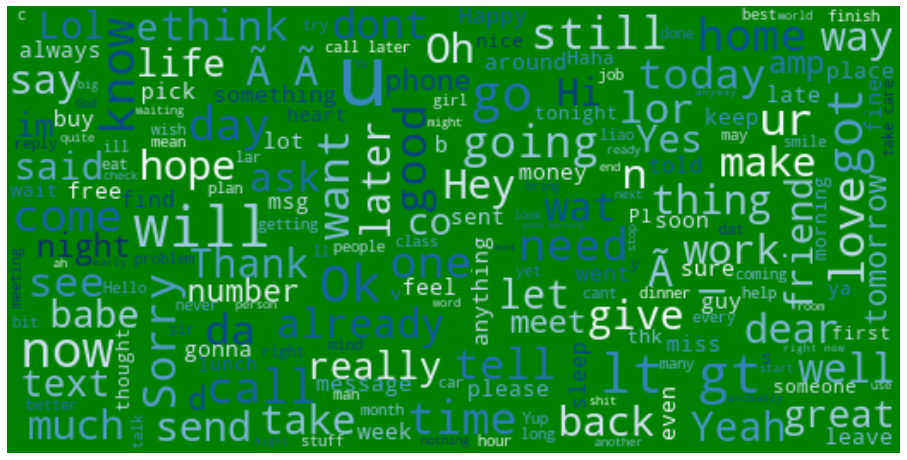

In [17]:
# wordcloud of ham messages
ham_msg_wcloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,
max_font_size=50, background_color ="green", colormap='Blues').generate(ham_msg_txt)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_wcloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

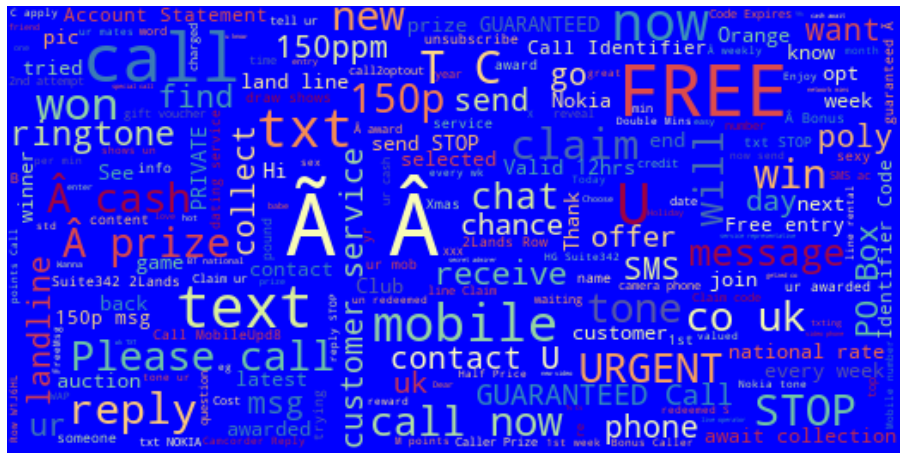

In [18]:
# wordcloud of spam messages
spam_msg_wcloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, 
background_color ="blue", colormap='Spectral_r').generate(spam_msg_txt)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_wcloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

/Users/yuvraj/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


15.481865284974095

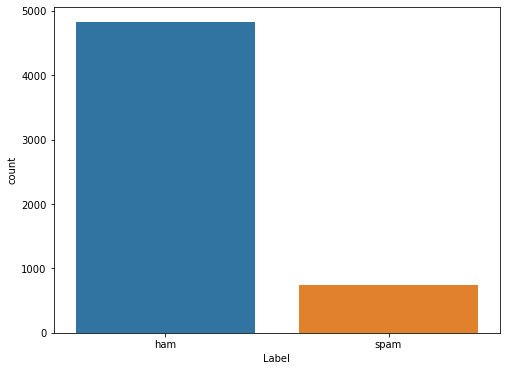

In [19]:
#visualize imbalanced data 
plt.figure(figsize=(8,6))
sns.countplot(data.Label)
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 

(747, 2) (747, 2)


/Users/yuvraj/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Message labels')

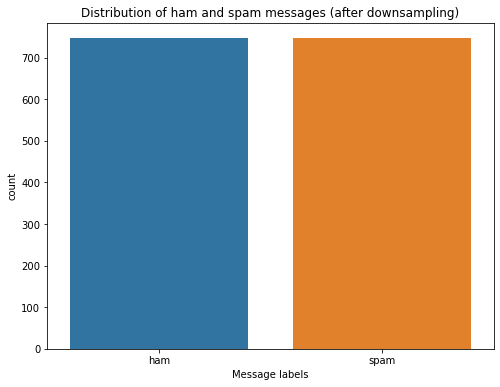

In [21]:
# downsampling the ham message count to the spam message count
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg


print(ham_msg_df.shape, spam_msg_df.shape)

#graph for better visualization 
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(msg_df.Label)
plt.title('Distribution of ham and spam messages (after downsampling)')
plt.xlabel('Message labels')

In [28]:
label=data['Label']
messages = data['EmailText']

In [30]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')


lemma=WordNetLemmatizer()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuvraj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yuvraj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
# cleaning each sent email by removing stopwords, numbers and
#lemmatising it after tokenization 
import re 
cleaned_sentences=[]
for msg in messages:
  sent=re.sub('[^A-Za-z]',' ',msg)
  sent=sent.lower()
  words=word_tokenize(sent)
  word=[lemma.lemmatize(i) for i in words if i not in stopwords.words('english')]
  sent=' '.join(word)
  cleaned_sentences.append(sent)

In [34]:
cleaned_sentences

['go jurong point crazy available bugis n great world la e buffet cine got amore wat',
 'ok lar joking wif u oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply',
 'u dun say early hor u c already say',
 'nah think go usf life around though',
 'freemsg hey darling week word back like fun still tb ok xxx std chgs send rcv',
 'even brother like speak treat like aid patent',
 'per request melle melle oru minnaminunginte nurungu vettam set callertune caller press copy friend callertune',
 'winner valued network customer selected receivea prize reward claim call claim code kl valid hour',
 'mobile month u r entitled update latest colour mobile camera free call mobile update co free',
 'gon na home soon want talk stuff anymore tonight k cried enough today',
 'six chance win cash pound txt csh send cost p day day tsandcs apply reply hl info',
 'urgent week free membership prize jackpot txt word claim c www dbuk net lccltd pobox ldnw rw

CREATING ML MODELS

In [38]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
label=le.fit_transform(label)

In [39]:
label

array([0, 0, 1, ..., 0, 0, 0])

In [40]:
le.classes_
# 1 => spam ; 0 => ham

array(['ham', 'spam'], dtype=object)

In [41]:
# Split in to Training and Test Data
from sklearn.model_selection import train_test_split

X = cleaned_sentences
Y = label

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.25,random_state=6)





In [42]:
x_test

['buzzzz grin buzz as buzz chest buzz cock keep phone vibrator feel shake',
 'pansy living jungle two year driving worried',
 'r going today meeting',
 'already sabarish asked go',
 'weekend fine excuse much decorating',
 'got look scrumptious daddy want eat night long',
 'sorry im stil fucked last nite went tobed got work',
 'min later k',
 'probably gon na swing wee bit',
 'class lt gt reunion',
 'private account statement show un redeemed point call identifier code expires',
 'money steve mate',
 'okie thanx',
 'sure whenever show fuck gt',
 'hope know still mad',
 'mobile number claim call u back ring claim hot line',
 'suck go u hair free right',
 'pattern recently crap weekend',
 'hi baby im cruisin girl friend r u give call hour home thats alright fone fone love jenny xxx',
 'urgent last weekend draw show cash spanish holiday call claim c rstm sw s ppm',
 'finished missing plenty',
 'co darren say considering mah ask',
 'putting ready lt time gt',
 'tried contact reply offer vid

In [43]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [55]:
# using CountVectorizer we can compare similarity of a given message with spam/ham message

cv = CountVectorizer()  
features = cv.fit_transform(x_train)

tuned_parameters = {'kernel': ['rbf','linear'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}

model = GridSearchCV(svm.SVC(), tuned_parameters)

model.fit(features,y_train)

print(model.best_params_)

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}


In [56]:
print(model.score(cv.transform(x_test),y_test))


0.9834888729361091


In [57]:
features=features.toarray()

features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Using Naive Bayes

In [65]:
NB_features = cv.fit_transform(cleaned_sentences)

feature_train,feature_test,label_train,label_test=train_test_split(NB_features,label,test_size=0.2,random_state=7)

NB=MultinomialNB()
NB.fit(feature_train,label_train)

label_pred=NB.predict(feature_test)



In [66]:
import sklearn.metrics as metrics

metrics.accuracy_score(label_test,label_pred)


0.979372197309417